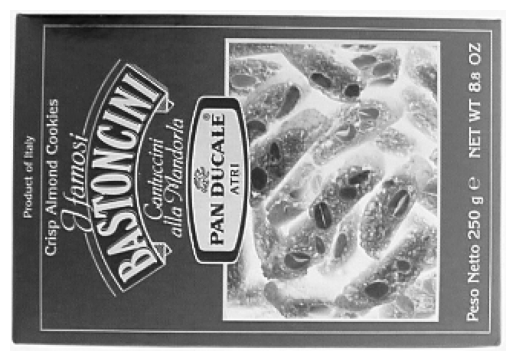

In [1]:
import math
import random
from typing import Union

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow
import numpy as np
import numpy.typing as npt


def get_image(filename: str) -> np.array:
    dir = "images/"
    image = Image.open(dir + filename)
    image_array = np.array(image)
    return image_array


def show_image(array: np.array, mode: Union[str, None] = 'Greys'):
    figure()
    plt.axis('off')
    imshow(array, cmap=mode)


show_image(get_image('box.png'))

In [2]:
def scale(img: npt.NDArray[int], multiplier: int):
    h, w = img.shape
    h //= multiplier
    w //= multiplier

    result_image = np.zeros((h, w), dtype=int)

    for i in range(0, h):
        for j in range(0, w):
            result_image[i, j] = int(
                np.mean(img[i * multiplier : (i + 1) * multiplier, j * multiplier : (j + 1) * multiplier])
            )

    return result_image

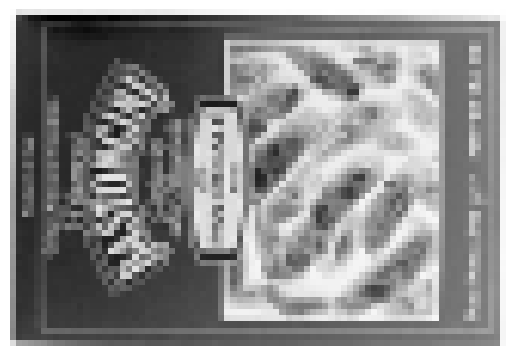

In [3]:
box = get_image("box.png")
test_image = get_image("box_in_scene.png")
box_x2 = scale(box, 2)
box_x4 = scale(box_x2, 2)
show_image(box_x4)

In [4]:
def get_gaussian(size: int, sigma: float = 0.84089642) -> npt.NDArray[float]:
    pad = size // 2

    K = np.zeros((size, size), np.float64)
    for x in range(-pad, -pad + size):
        for y in range(-pad, -pad + size):
            K[x + pad, y + pad] = np.exp(-(x * x + y * y) / (2 * (sigma * sigma)))
    K /= 2 * np.pi * sigma * sigma
    K /= K.sum()
    return K

In [5]:
def fast(image, r, t):

    h, w = image.shape

    result = []
    for i in range(r // 2, h - r // 2):
        for j in range(r // 2, w - r // 2):
            p = image[i, j]
            low_arc = np.concatenate(
                (
                    image[i : i + 2, j - 3],
                    image[i + 2, j - 2],
                    image[i + 3, j - 1 : j + 2],
                    image[i + 2, j + 2],
                    image[i : i + 2, j + 3],
                ),
                axis=None,
            )
            right_arc = np.concatenate(
                (
                    image[i + 3, j : j + 2],
                    image[i + 2, j + 2],
                    image[i - 1 : i + 2, j + 3],
                    image[i - 2, j + 2],
                    image[i - 3, j : j + 2],
                ),
                axis=None,
            )
            full_arc = np.concatenate(
                (
                    image[i - 1 : i + 2, j - 3],
                    image[i + 2, j - 2],
                    image[i + 3, j - 1 : j + 2],
                    image[i + 2, j + 2],
                    image[i - 1 : i + 2, j + 3],
                    image[i - 2, j + 2],
                    image[i - 3, j - 1 : j + 2],
                    image[i - 2, j - 2],
                ),
                axis=None,
            )
            count = 0
            if all(q > p + t for q in low_arc) or all(q > p + t for q in right_arc):
                for q in np.concatenate((full_arc, full_arc), axis=None):
                    # два прохода, чтобы рассмотреть стык в начале окружнсти
                    if q > p + t:
                        count += 1
                    else:
                        count = 0
                    if count >= 12:
                        result.append((i, j))
                        break
            elif all(q < p - t for q in low_arc) or all(q < p - t for q in right_arc):
                for q in np.concatenate((full_arc, full_arc), axis=None):
                    if q < p - t:
                        count += 1
                    else:
                        count = 0
                    if count >= 12:
                        result.append((i, j))
                        break
    return result

In [6]:
fast_box = fast(box, 31, 30)
fast_box_x2 = fast(box_x2, 31, 30)
fast_box_x4 = fast(box_x4, 31, 30)
fast_test = fast(test_image, 31, 30)

In [7]:
def get_W(sigma2):
    # попробовать заменить на свой гауссиан
    const1 = 2 * sigma2
    const2 = 2 * np.pi * sigma2

    G = np.zeros((5, 5), dtype=np.float64)

    for i in range(5):
        for j in range(5):
            G[i, j] = np.power(np.e, -((i - 3) ** 2 + (j - 3) ** 2) / const1) / const2

    G /= np.sum(G)
    return G

In [8]:
# W = get_W(100)
W = get_gaussian(5)
# print(W)

In [9]:
def get_gradient(image):
    h, w = image.shape

    img_copy = np.zeros((h + 1, w + 1), dtype=int)

    for i in range(h):
        for j in range(w):
            img_copy[i + 1, j + 1] = image[i, j]

    gradient = np.zeros((h + 1, w + 1, 2), dtype=float)

    for i in range(1, h):
        for j in range(1, w):
            gradient[i, j, 0] = (
                img_copy[i + 1, j]
                - img_copy[i - 1, j]
                + img_copy[i + 1, j - 1]
                - img_copy[i - 1, j - 1]
                + img_copy[i + 1, j + 1]
                - img_copy[i - 1, j + 1]
            ) / 6
            gradient[i, j, 1] = (
                img_copy[i, j + 1]
                - img_copy[i, j - 1]
                + img_copy[i - 1, j + 1]
                - img_copy[i - 1, j - 1]
                + img_copy[i + 1, j + 1]
                - img_copy[i + 1, j - 1]
            ) / 6

    return gradient[1 : h + 1, 1 : w + 1]

In [10]:
grad_box = get_gradient(box)
grad_box_x2 = get_gradient(box_x2)
grad_box_x4 = get_gradient(box_x4)

In [11]:
grad_test = get_gradient(test_image)

In [12]:
def __get_M(image, grad, x, y):
    h, w = image.shape
    # w = image.shape[0]
    # h = image.shape[1]

    image_copy = np.zeros((h + 4, w + 4), dtype=int)
    image_copy[2 : h + 2, 2 : w + 2] = image

    M = np.zeros((2, 2), dtype=float)
    for i in range(x - 2, x + 3):
        for j in range(y - 2, y + 3):
            Ix = grad[i, j, 0]
            Iy = grad[i, j, 1]
            A = np.array([[Ix**2, Ix * Iy], [Ix * Iy, Iy**2]], dtype=float).reshape((2, 2))
            # A.shape = (2, 2)
            new = np.sum(W * image_copy[i - 2 + 2 : i + 3 + 2, j - 2 + 2 : j + 3 + 2]) * A
            M = np.add(M, new)
    return M

In [13]:
def get_M(image, grad, fast_points):
    # M = []
    # for x, y in F:
    #     m = __get_M(image, grad, x, y)
    #     M.append(m)
    return [__get_M(image, grad, x, y) for x, y in fast_points]

In [14]:
M_box = get_M(box, grad_box, fast_box)
M_box_x2 = get_M(box, grad_box_x2, fast_box_x2)
M_box_x4 = get_M(box, grad_box_x4, fast_box_x4)

In [15]:
M_test = get_M(test_image, grad_test, fast_test)

На основе значения критерия R = det(M) - k*(tr(M))^2 принять решение о фильтрации ключевой точки. Параметр k выбрать из интервала [0.04, 0.06].

In [16]:
# def __get_R(m, k):
#     return
#     return r

In [17]:
def get_R(M, k):
    # R = []
    # for m in M:
    #     r = get_R(m, k)
    #     R.append(r)
    return [np.linalg.det(m) - k * np.trace(m) ** 2 for m in M]

In [18]:
k = 0.04
R_box = get_R(M_box, k)
R_box_x2 = get_R(M_box_x2, k)
R_box_x4= get_R(M_box_x4, k)
print(R_box)
print(R_box_x2)
print(R_box_x4)

[48196133340.98035, 15970961401.910378, 37851468218.585144, 97287090736.77179, 130198767569.14815, -4987709362.166199, 23770159729.80475, 98728854098.33426, -82993299345.76297, 341969441676.14087, 397602271731.7699, 362895094441.9472, 3403751846431.1997, 95321341097.76163, 282199503716.0452, 2937167048350.7686, -336429177119.3418, 22547921390.110123, 455437826915.6127, 51638455225.60596, 38814965264.31938, 4028260992732.784, 591574024334.1575, 4932370531788.312, 8473071732744.231, 3928843879103.9966, 624461775265.4585, 356473396058.8519, 785311703469.283, 714619331063.298, 157988501213.1252, 194377258223.11884, 3589641510174.554, 3353816061392.663, -117486468087.53789, 4861669885517.975, -123340096082.9542, 1263165471192.6226, 138428896388.7901, -104044752958.3257, -54704883022.833984, 95086054494.52014, 8337992227.4107895, -87067901650.35321, 35224475434.28937, -105654691271.91614, 393302334521.5703, -97672071191.8437, -218923085023.20105, 127051460126.05127, 234153558824.43878, 47374

In [19]:
R_test = get_R(M_test, k)
print(R_test)

[1337825318.14401, 1342173105.9700146, 1121440753298.921, 582310836144.4917, 1604129338996.5164, 458875166307.59845, 324617579858.5519, 224831069879.22272, 2696075579639.5664, 1572336081051.7302, 2651420638207.6353, 1363142877268.1882, 4423487574.005012, 1589743462650.1729, 1348393949274.7776, 1663970724128.581, 990829649926.9987, 2332679870637.867, 2529266499350.377, 2028063574551.3257, 1395095051508.9844, 3608424959719.8833, 2410236276456.586, 1448204459890.1165, 412038442068.22754, 3479429361261.964, 2928437305203.081, 355966785542.99365, 969365541364.2479, 1031111647596.3604, 1332921699762.6033, 748890330149.0814, 74028341282.17392, 677597332152.2959, 52810051834.07295, 949380728919.6385, 1230268206834.082, 628776685342.5757, 1624537486690.9924, 882260019334.1475, 3020804112703.4004, 385425652899.6521, 429565149526.50916, 125802820829.59824, 1765110684516.6204, 1981716590285.0413, 730821410370.4192, -176225136584.414, 1806720459789.4343, 626874108184.1785, 2767421869888.6206, 23455

Отфильтровать точки по убыванию значения критерия Харриса и выбрать первые N точек.

In [20]:
def harris(fast_points, R, size):
    point_R = dict()
    for i in range(len(fast_points)):
        point_R[fast_points[i]] = R[i]

    d = dict(sorted(point_R.items(), key=lambda item: item[1], reverse=True)[0:size])
    m = size
    for key in reversed(list(d.keys())):
        if d[key] >= 0:
            break
        m -= 1
    points = list(d.keys())[0:m]
    return points

In [21]:
points_box = harris(fast_box, R_box, 500)
points_box_x2 = harris(fast_box_x2, R_box_x2, len(fast_box_x2))
points_box_x4 = harris(fast_box_x4, R_box_x4, len(fast_box_x4))
# print(len(points_box), points_box)
# print(len(F12), len(points_box_x2), points_box_x2)
# print(len(F14), len(points_box_x4), points_box_x4)

In [22]:
points_test = harris(fast_test, R_test, 500)
# print(len(points_test), points_test)

In [23]:
def get_image_with_points(img: npt.NDArray[int], points: npt.NDArray[int]) -> npt.NDArray[int]:
    h, w = img.shape
    result_image = np.zeros((h, w, 3), dtype=int)
    result_image[:, :, 0] = img[:, :]
    result_image[:, :, 1] = img[:, :]
    result_image[:, :, 2] = img[:, :]

    point_color = (255, 0, 0)
    figure()
    for p in points:
        i, j = p
        result_image[i - 1 : i + 1, j - 1 : j + 1] = point_color

    return result_image

<Figure size 640x480 with 0 Axes>

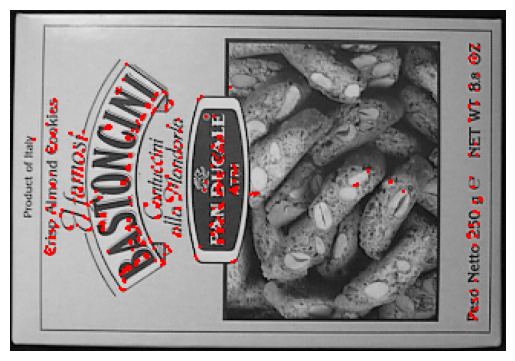

<Figure size 640x480 with 0 Axes>

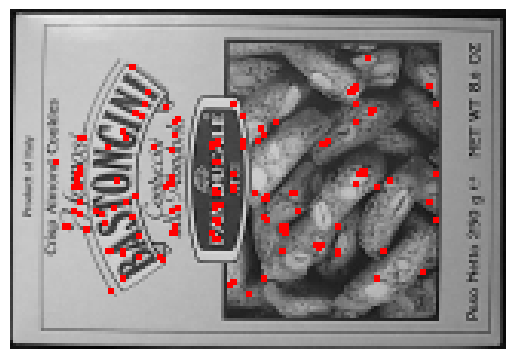

<Figure size 640x480 with 0 Axes>

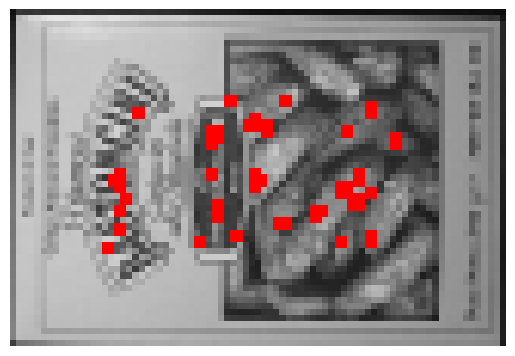

<Figure size 640x480 with 0 Axes>

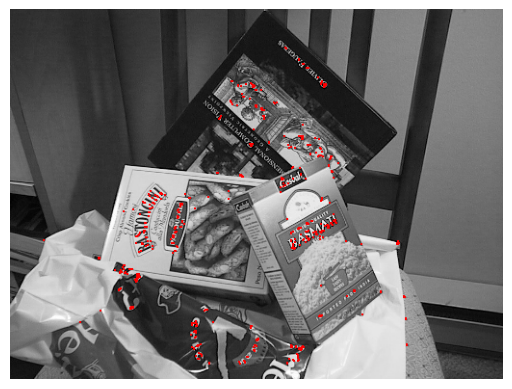

In [24]:
show_image(get_image_with_points(box, points_box))
show_image(get_image_with_points(box_x2, points_box_x2))
show_image(get_image_with_points(box_x4, points_box_x4))
show_image(get_image_with_points(test_image, points_test))

In [25]:
def get_moment(image, p, q, x, y, r):
    h, w = image.shape
  # w = image.shape[0]
  # h = image.shape[1]

    ci = h // 2
    cj = w // 2

    m = 0
    for i in range(max(0, x-r), min(h, x+r+1)):
        for j in range(max(0, y-r), min(w, y+r+1)):
            m += (i-ci)**p * (j-cj)**q * image[i, j]
    return m

In [26]:
def get_angles(image, points, r):
    angles = []
    for x, y in points:
        m01 = get_moment(image, 0, 1, x, y, r)
        m10 = get_moment(image, 1, 0, x, y, r)
        a = math.atan2(m01, m10) % (2*np.pi)
        angles.append(a)

    return angles

In [27]:
angles_box = get_angles(box, points_box, 31)
angles_box_x2 = get_angles(box_x2, points_box_x2, 31)
angles_box_x4 = get_angles(box_x4, points_box_x4, 31)
# print(A1)
# print(A12)
# print(A14)

In [28]:
angles_test = get_angles(test_image, points_test, 31)
# print(A2)

Перед построением дескриптора изображение необходимо сгладить с помощью фильтра Гаусса

In [29]:
def filter_gauss(K_size, sigma, im):
    H, W = im.shape

    pad = K_size // 2
    out = np.zeros((H + pad * 2, W + pad * 2), np.float64)
    out[pad: pad + H, pad: pad + W] = im.copy().astype(np.float64)

    K = np.zeros((K_size, K_size), np.float64)
    for x in range(-pad, -pad + K_size):
        for y in range(-pad, -pad + K_size):
            K[x + pad, y + pad] = np.exp( -(x * x + y * y) / (2 * (sigma * sigma)))
    K /= 2 * np.pi * sigma * sigma
    K /= K.sum()

    tmp = out.copy()

    for y in range(H):
        for x in range(W):
            out[pad + y, pad + x] = np.sum(K * tmp[y: y + K_size, x: x + K_size])
    out = np.clip(out, 0, 255).astype(int)
    return out[pad: pad + H, pad: pad + W]

In [30]:
blurred_box = filter_gauss(3, 100, box)
blurred_box_x2 = filter_gauss(3, 100, box_x2)
blurred_box_x4 = filter_gauss(3, 100, box_x4)
blurred_test = filter_gauss(3, 100, test_image)

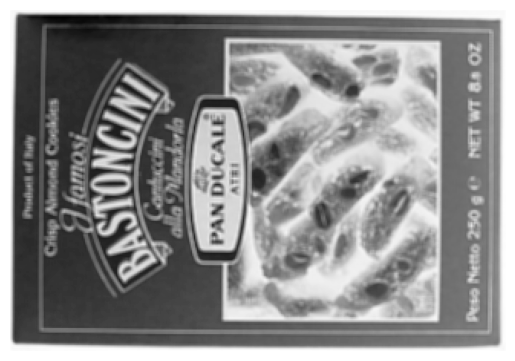

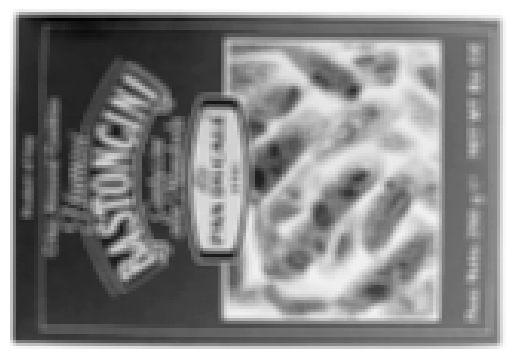

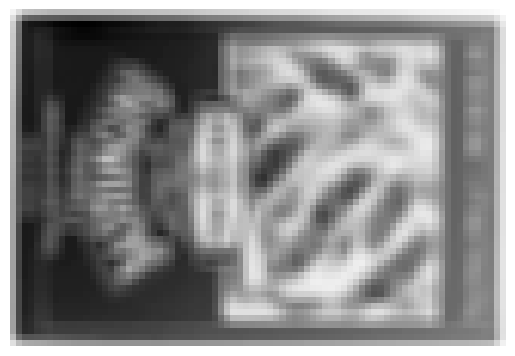

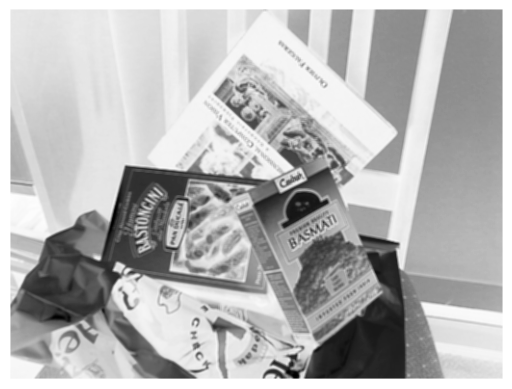

In [31]:
show_image(blurred_box)
show_image(blurred_box_x2)
show_image(blurred_box_x4)
show_image(blurred_test)

In [32]:
# theta = [2*k*np.pi/30 for k in range(30)]
theta = np.linspace(0, 2 * np.pi, 30, endpoint=False)
print(theta)
# print(len(theta), theta)

[0.         0.20943951 0.41887902 0.62831853 0.83775804 1.04719755
 1.25663706 1.46607657 1.67551608 1.88495559 2.0943951  2.30383461
 2.51327412 2.72271363 2.93215314 3.14159265 3.35103216 3.56047167
 3.76991118 3.97935069 4.1887902  4.39822972 4.60766923 4.81710874
 5.02654825 5.23598776 5.44542727 5.65486678 5.86430629 6.0737458 ]


In [33]:
Rt = [np.array([[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]]) for t in theta]

In [34]:
S = (np.pi / 5) * np.random.randn(256, 2, 2)

In [35]:
S /= np.max(S)
S *= (31 // 2 - 2)
# print(S)

In [36]:
St = []
for rt in Rt:
    st = []
    for i in range(S.shape[0]):
        st.append(np.array([rt.dot(S[i, 0]), rt.dot(S[i, 1])], dtype=int))
    St.append(st)

In [37]:
def get_descriptor(image, points, angles, n = 256):
    def tau(p, x, y):
        return p[x[0], x[1]] < p[y[0], y[1]]

    descriptor = []
    for j in range(len(points)):
        c = points[j]

        t = len(theta)-1
        for i in range(len(theta)):
            if angles[j] < theta[i]:
                t = i-1
                break
        s = [[St[t][i][0] + c, St[t][i][1] + c] for i in range(n)]
        f = [tau(image, s[i][0], s[i][1]) for i in range(n-1, -1, -1)]
        descriptor.append(np.array(f, dtype=int))

    return descriptor

In [38]:
desc_box = get_descriptor(blurred_box, points_box, angles_box)

In [39]:
desc_box_x2 = get_descriptor(blurred_box_x2, points_box_x2, angles_box_x2)
desc_box_x4 = get_descriptor(blurred_box_x4, points_box_x4, angles_box_x4)

In [40]:
desc_test = get_descriptor(blurred_test, points_test, angles_test)

## Начало 6-ой лабы

In [41]:
def descriptor_comparison_matrix(d1, d2):
  w = len(d1)
  h = len(d2)
  h_dist = np.zeros((w, h), dtype=int)

  for i in range(w):
    for j in range(h):
      v1 = d1[i]
      v2 = d2[j]
      d = sum(np.absolute(v1-v2))
      h_dist[i, j] = d

  return h_dist

In [42]:
h_dist_box = descriptor_comparison_matrix(desc_box, desc_test)
print(h_dist_box)

[[148 168  95 ... 122  90  92]
 [162 156 109 ... 126 110 116]
 [134 164 103 ...  92  92  78]
 ...
 [ 75  95 140 ... 157 155 157]
 [159 169  70 ... 127 105 111]
 [104 106 153 ... 160 140 156]]


In [43]:
h_dist_box_x2 = descriptor_comparison_matrix(desc_box_x2, desc_test)
print(h_dist_box_x2)

[[162 150 111 ... 106 108  82]
 [ 93  93 144 ... 175 147 165]
 [158 160 121 ...  90  80  98]
 ...
 [116 108 165 ... 136 120 146]
 [114 108 159 ... 106 116 106]
 [115 147 102 ... 163 111 137]]


In [44]:
h_dist_box_x4 = descriptor_comparison_matrix(desc_box_x4, desc_test)
print(h_dist_box_x4)

[[135 111 144 ... 139 119 113]
 [131 119 164 ... 113 127 111]
 [143 135 128 ... 141  93  91]
 ...
 [163 159 120 ... 127 111 131]
 [ 99 111 154 ... 183 145 163]
 [134 142 133 ... 116 126 114]]


Использовать тест Lowe и Cross Check для определения лучших матчей.

In [45]:
def Lowe_test(points1, points2, h_dist):
    R_Lowe = 0.8
    h, w = h_dist.shape

    result = []

    for i in range(h):
        sorted_dist = sorted(h_dist[i])
        for t in range(len(sorted_dist)-1):
            dist1, dist2 = sorted_dist[t:t+2]
            R = dist1/dist2
            if R < R_Lowe:
                j = np.argwhere(h_dist[i] == dist1)[0][0]
                result.append([points1[i], points2[j]])
                break
    return result

In [46]:
lowe_box = Lowe_test(points_box, points_test, h_dist_box)
lowe_box_reversed = Lowe_test(points_test, points_box, np.transpose(h_dist_box))
print(len(lowe_box), len(lowe_box_reversed))
print(lowe_box)

14 8
[[(72, 86), (225, 327)], [(129, 137), (290, 115)], [(95, 78), (172, 240)], [(158, 64), (156, 332)], [(75, 24), (244, 365)], [(130, 24), (244, 365)], [(89, 138), (132, 300)], [(149, 26), (237, 315)], [(114, 73), (244, 137)], [(109, 136), (290, 115)], [(152, 136), (341, 192)], [(159, 27), (258, 92)], [(173, 72), (192, 182)], [(172, 74), (171, 302)]]


In [47]:
lowe_box_x2 = Lowe_test(points_box_x2, points_test, h_dist_box_x2)
lowe_box_x2_reversed = Lowe_test(points_test, points_box_x2, np.transpose(h_dist_box_x2))
print(len(lowe_box_x2), len(lowe_box_x2_reversed))
print(lowe_box_x2)

11 46
[[(79, 33), (243, 131)], [(79, 32), (243, 131)], [(88, 37), (252, 134)], [(75, 67), (243, 168)], [(81, 42), (246, 141)], [(80, 37), (244, 137)], [(64, 67), (237, 169)], [(79, 37), (243, 137)], [(60, 68), (292, 358)], [(59, 73), (226, 178)], [(79, 89), (271, 109)]]


In [48]:
lowe_box_x4 = Lowe_test(points_box_x4, points_test, h_dist_box_x4)
lowe_box_x4_reversed = Lowe_test(points_test, points_box_x4, np.transpose(h_dist_box_x4))
print(len(lowe_box_x4), len(lowe_box_x4_reversed))
print(lowe_box_x4)

1 31
[[(29, 40), (366, 244)]]


In [49]:
def cross_check(lowe_forward, lowe_reversed):
    points1 = []
    points2 = []
    for p1, p2 in lowe_forward:
        for pr1, pr2 in lowe_reversed:
            if p1 == pr2 and p2 == pr1:
                points1.append(p1)
                points2.append(p2)
    return points1, points2

In [50]:
cc_box = cross_check(lowe_box, lowe_box_reversed)
print(len(cc_box[0]), cc_box)

0 ([], [])


In [51]:
cc_box_x2 = cross_check(lowe_box_x2, lowe_box_x2_reversed)
print(len(cc_box_x2[0]), cc_box_x2)

6 ([(79, 32), (88, 37), (81, 42), (80, 37), (59, 73), (79, 89)], [(243, 131), (252, 134), (246, 141), (244, 137), (226, 178), (271, 109)])


In [52]:
cc_box_x4 = cross_check(lowe_box_x4, lowe_box_x4_reversed)
print(len(cc_box_x4[0]), cc_box_x4)

0 ([], [])


In [53]:
def bresenham(x0, y0, x1, y1, size):
    steps_num = int(np.max([np.abs(x0 - x1), np.abs(y0 - y1)]))
    sp = np.linspace(0, 1, steps_num + 1)

    x_coords = np.int32(np.round(x0 * sp + x1 * (1 - sp)))
    y_coords = np.int32(np.round(y0 * sp + y1 * (1 - sp)))

    x_ind = (x_coords > 0) & (x_coords < size)
    y_ind = (y_coords > 0) & (y_coords < size)
    ind = x_ind & y_ind

    x_coords = x_coords[ind]
    y_coords = y_coords[ind]

    return [a for a in zip(x_coords, y_coords)]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

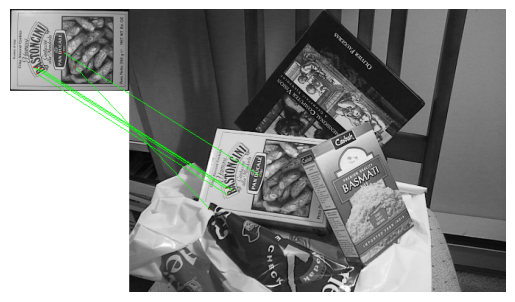

In [54]:
points1, points2 = cc_box_x2

detection = get_image_with_points(box_x2, points1)
picture = get_image_with_points(test_image, points2)

color = 0, 255, 0

w = detection.shape[1] + picture.shape[1]
h = max(detection.shape[0], picture.shape[0])

result_image = np.ones((h, w, 3), dtype=int) * 255
result_image[:detection.shape[0], :detection.shape[1]] = detection
result_image[:picture.shape[0], detection.shape[1]:] = picture


for i in range(len(points1)):
    x, y = points1[i]
    x2, y2 = points2[i]
    y2 += detection.shape[1]

    line = bresenham(x, y, x2, y2, h)
    for u, v, in line:
        result_image[u, v] = color

show_image(result_image)

## Оценка параметров